## KALM 

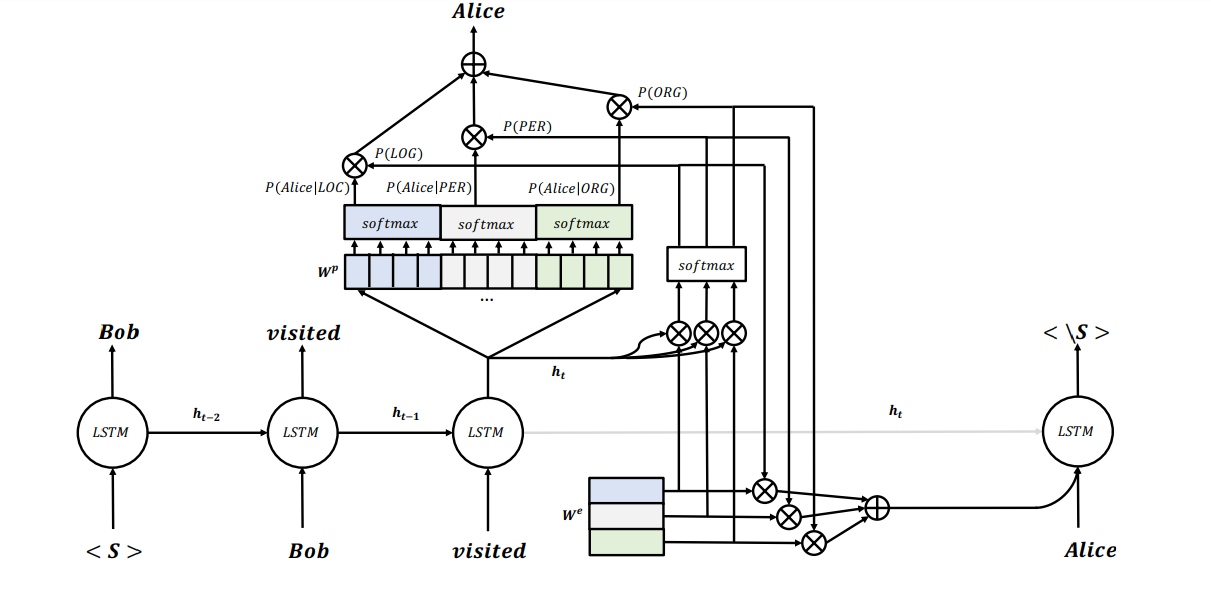

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import os

from tensorflow.keras.layers import Dense,Flatten,Dropout,RepeatVector,Embedding,Input,LSTM
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [2]:
# Standard parameters
BATCH_SIZE = 64
embedding_dim = 400
dec_units = 1150
WH_UNITS = WE_UNITS = 100
VOCAB_SIZE = 5000
NB_ENTITIES = 4

In [ ]:
# TypeEmbedding layer

class TypeEmbedding(tf.keras.layers.Layer):
    
    def __init__(self,nb_entities,wh_units,we_units):
        
        super(TypeEmbedding,self).__init__()
        
        assert type(nb_entities) == int , "Please provide integer number to number of entities"
        
        self.Wh = Dense(wh_units)
        self.We = [Dense(we_units) for _ in range(nb_entities)]
        
    def call(self,hidden_state):
        
        # hidden_state == hidden_states i.e (bs,hidden_size)
        # Wh is used for dimentionality reduction as mentioned in paper and is shared.
        
        reduced_dimentionality = self.Wh(hidden_state)    # (bs,wh_units) i.e. (bs,400)
        
        outputs = []
        
        for we in self.We:
            logits = we(reduced_dimentionality)
            logits = tf.expand_dims(logits,axis = 0)            # (1,bs,we_units)
            outputs.append(logits)
            
        outputs = tf.concat(outputs,axis=0)  # (nb_entities,bs,we_units)
        
        outputs = tf.transpose(outputs,perm = [1,0,2])  # (bs,nb_entities,we_units)
        outputs = tf.nn.softmax(outputs,axis= -1)      # (bs,nb_entities,we_units)
        
        # code for vt
        vt = []
        
        for i in range(len(self.We)):
            logits = self.We[i](outputs[:,i,:])
            logits = tf.expand_dims(logits,axis = 0) # (1,bs,we_units)
            vt.append(logits)
            
        result = tf.concat(vt,axis=0)                   # (nb_entities,bs,we_units)
        result = tf.transpose(result,perm= [1,2,0] )  # (bs,we_uninb_entities)
        result = tf.reduce_sum(result,axis = -1)        # (bs,we_units)
            
        return outputs,result                 # (bs,nb_entities,units)  (bs,we_units)

In [ ]:
# test code for type embedding

decoder = Decoder(VOCAB_SIZE,embedding_dim,dec_units,BATCH_SIZE,NB_ENTITIES,WH_UNITS,WE_UNITS)
hidden_ = decoder.initialize_hidden_state()

print(hidden_.shape)

type_emb = TypeEmbedding(NB_ENTITIES,WH_UNITS,WE_UNITS)
type_prob,vt = type_emb(hidden_)

print(type_prob.shape,vt.shape)

In [ ]:
# Projection layer W(p,j) for j = 1,2,...K

class ProjectionLayer(tf.keras.layers.Layer):
    
    def __init__(self,nb_entities,wp_units):
        
        super(ProjectionLayer,self).__init__()
        
        assert type(nb_entities) == int , "Please provide integer number to number of entities"
        self.Wp = [Dense(wp_units) for _ in range(nb_entities)]
        
    def call(self,inputs,type_prob):
        
        # expected inputs are hidden states of lstm. i.e (batch_size,hidden_units)
        # type_prob - (bs,nb_entites,we_units)
        
        outputs = []
        for wp in self.Wp:
            logits = wp(inputs)
            logits = tf.nn.softmax(logits,axis = -1)   # (bs,units)
            logits = tf.expand_dims(logits,axis = 0)            # (1,bs,units)
            outputs.append(logits)
            
        outputs = tf.concat(outputs,axis=0)  # (nb_entities,bs,units)
        
        outputs = tf.transpose(outputs,perm = [1,2,0])  # (bsb,nb_entities,units)
        
        result = tf.matmul(outputs,type_prob)
        result = tf.reduce_sum(result,axis=-1)    # (bs,ts,vg)
        
        return result
        

In [ ]:
# test code for projection layer

proj = ProjectionLayer(NB_ENTITIES,VOCAB_SIZE)
result = proj(hidden_,type_prob)
print(result.shape)

In [ ]:
class Decoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,nb_entities,wh_units,we_units):
        
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        self.lstm_1 = tf.keras.layers.LSTM(self.dec_units,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform')
        self.lstm_2 = tf.keras.layers.LSTM(self.dec_units,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform')

        self.lstm_3 = tf.keras.layers.LSTM(self.dec_units,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform')
        
        self.type_emb = TypeEmbedding(nb_entities,wh_units,we_units)
        self.projection = ProjectionLayer(nb_entities,vocab_size)


    def call(self, x, hidden_state):
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        print("Embedding : ",x.shape)
        
        
        # Call for TypeEmbedding Layer to get vt and type_probabilities
        # type_prob (bs,nb_entities,we_units) and vt shape is (bs,we_units)
        type_prob , vt = self.type_emb(hidden_state)

        print("After type :",type_prob.shape,vt.shape)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(vt, 1), x], axis=-1)
        
        print("LSTM input = ",x.shape)
        hidden = self.lstm_1(x)
        hidden = self.lstm_2(hidden)
        hidden = self.lstm_3(hidden)
        
        print("Final op : ",hidden.shape)
        # output shape == (batch_size * 1, hidden_size)
        hidden = tf.reshape(hidden, (-1, hidden.shape[2]))

        # output shape == (batch_size, vocab)
        final_result = self.projection(hidden,type_prob)
        
        
        
        return hidden, final_result
    
    def initialize_hidden_state(self,batch = None):
        if batch:
            return tf.zeros((batch, self.dec_units))
        return tf.zeros((self.batch_sz, self.dec_units))

In [4]:
if not None:
    print("bbli")

bbli


In [ ]:
# Test code for decoder

in_ = Input(shape=(1,),batch_size=None)
print(in_.shape)

decoder = Decoder(VOCAB_SIZE,embedding_dim,dec_units,BATCH_SIZE,NB_ENTITIES,WH_UNITS,WE_UNITS)
hidden_ = decoder.initialize_hidden_state()

hidden,final_ = decoder(in_,hidden_)

print(hidden.shape,final_.shape)

In [5]:
import tensorflow as tf
a = [1, 10, 26.9, 2.8, 166.32, 62.3]
b = tf.math.argmax(input = a)
c = tf.keras.backend.eval(b)
# c = 4
# here a[4] = 166.32 which is the largest element of a across axis 0

In [6]:
b

<tf.Tensor: id=2, shape=(), dtype=int64, numpy=4>